# Uniform Design

**For this design, we aim to spread sample sites uniformly within the range of the metric.**

In this notebook we will first show the concept of the design using a single metric, we will then show how it can be run for multiple metric designs. Example files can be used to test the code. These consist of:

 - HabitatMap.tif: _a binary map showing forest/non-forest_
 - DistanceToEdgeLog2.tif: _distance to the nearest habitat edge at log 2 scale (derived from the habitat map)_
 - FragmentAreaLog10.tif: _fragment area a log 10 scale (also dervied from the habitat map)_
 - InvalidAreasMask.tif: _a mask showing valid areas (valid = 1/ invalid = 0)_

<div class="alert alert-block alert-info">
<b>Tip:</b> To run a code cell, click in the cell and either:
<ul>
  <li>Click 'Run' in the top panel</li>
  <li>OR use the keyboard shortcut 'shift' + 'enter'</li>
</ul>
</div>

<b> Cells must be run sequentially, to ensure all variables are loaded at each stage </b>

### Import required libraries

In [1]:
import os
from osgeo import gdal, osr, ogr
import numpy as np
from random import randint
from scipy import ndimage
from copy import copy
import time
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

def get_file_info(file_path):
    """
    Function which extracts a geo tiff file as numpy array, and saves geographic projection information
    INPUTS:
        file_path: (str) Path to the file
    OUTPUTS:
        file_map: (np.array) The extracted map
        n_bins: (int) The number of categories in the map
        res: (float) Resolution of the map in meters
        geo_t: (list) The geographic transform used to project the map
    """
    file_raw = gdal.Open(file_path)
    prj_info = file_raw.GetProjection()
    geo_t = file_raw.GetGeoTransform()
    res = geo_t[1]
    file_map = file_raw.ReadAsArray()
    n_bins = len(np.unique(file_map))
    return file_map, n_bins, res, geo_t, prj_info

def save_as_shp(x, y, geo_t, out_filename):
    """
    Export sample site locations to shape file, to be read into software like ArcMap
    INPUTS:
        x: (list) x coordinates of sample sites
        y: (list) y coordinates of sample sites
        geo_t: (list) geographic transformation values extracted from geo-tiff
        out_filename: (str) path and name of the output shape file
    OUTPUTS:
        Saves .shp file in the directory specified by out_filename
    """
    # Create the ESRI shape file
    driver = ogr.GetDriverByName('ESRI Shapefile')
    ds = driver.CreateDataSource(out_filename)

    layer = ds.CreateLayer('', None, ogr.wkbPoint)
    for i in range(len(x)):
        feature = ogr.Feature(layer.GetLayerDefn())

        # Project row and column (will be for bottom left corner)
        x_proj = y[i] * geo_t[1] + geo_t[0]
        y_proj = x[i] * geo_t[5] + geo_t[3]

        # Shift from bottom left to centre of the pixel
        x_proj += geo_t[1] / 2.0
        y_proj += geo_t[5] / 2.0

        # Add each point to new geometry
        point = ogr.Geometry(ogr.wkbPoint)
        point.AddPoint(x_proj, y_proj)
        feature.SetGeometry(point)
        layer.CreateFeature(feature)
        feature.Destroy()

    # Delete driver once finished
    ds.Destroy()
    return  

def extract_raster(tif_path):
    """
    Extract array from satellite image of study location.
    *Same as get_file_info but without geo-information
    INPUTS:
        file_path: (string) Relative path to .tif file
    OUTPUTS:
        file_map: (.npy array) 2D numpy array of study site
    """
    tif_raw = gdal.Open(tif_path)
    return tif_raw.ReadAsArray()

# Single metric example

## User Inputs

<div class="alert alert-block alert-info">
<b>Note:</b> Sections where users can enter their own values are highlighted with #'s. 
    
<b>Current entries link to example files downloaded from Dropbox, which can be used for testing. </b>
</div>

Specify a unique name for the project as `save_path`. A folder with your chosen name will be created in the `results` folder, and all outputs for the design will be saved there. E.g:

In [2]:
###################################
save_path = 'Uniform_Design_Demo'
###################################

In [3]:
directory = 'results/{}'.format(save_path)
if not os.path.exists(directory):
    os.makedirs(directory)
    
print('Results will be saved in the folder {}'.format(directory))

Results will be saved in the folder results/Uniform_Design_Demo


### Number of sample sites
Enter an integer number of sample sites. This can be an estimated number based on time and resources for your study. 

Later we suggest upper and lower bounds to provide a better sample of the metric space.

In [4]:
#################
nsp = 57
################

### Habitat category map
Enter name of the habitat/non-habitat map used to derive your metrics. This should be in GeoTiff format. E.g:

In [5]:
#############################
hab_path = 'raw/HabitatMap.tif'
#############################

**Load** the map and extract the projection information...

In [6]:
print('Loading {} ...'.format(hab_path))

habmap, hab_bins, res, geo_t, prj_info = get_file_info(hab_path)

print('\nNumber of habitat categories in map: {}'.format(hab_bins))
print('Pixel resolution (m): {}'.format(res))
print('GeoT info: {}'.format(geo_t))

Loading raw/HabitatMap.tif ...

Number of habitat categories in map: 2
Pixel resolution (m): 30.0
GeoT info: (604343.5084861958, 30.0, 0.0, 5302852.190465175, 0.0, -30.0)


Now **plot** the map. This should be categorical (e.g habitat and non-habitat)...

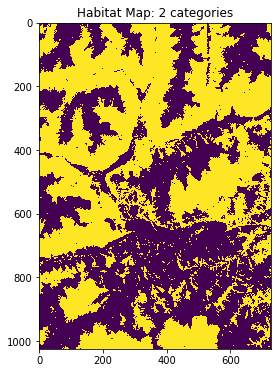

In [7]:
plt.figure(figsize=(6, 6))
plt.imshow(habmap)
plt.title('Habitat Map: {} categories'.format(len(np.unique(habmap))))
plt.show()

### Invalid areas mask
Enter path to invalid areas mask (if there are any you wish to exclude). This can be used to mask out things like inaccessible areas, high altitudes, or habitat categories which you do not wish to sample in. 

**In this example we will mask out one of the habitat categories (for example exclude all non-forest areas). This way we can see how the method works in the simplest single habitat, single metric case**

In [8]:
######################################
mask_path = 'raw/InvalidAreasMask.tif'
######################################

Extract the mask...

In [9]:
mask = extract_raster(mask_path)

Now **plot** the mask...

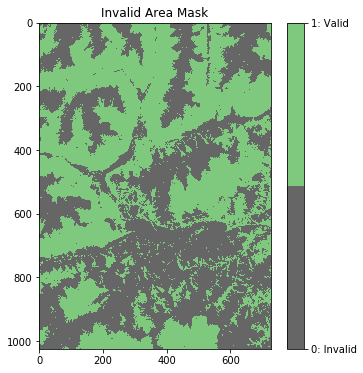

In [10]:
plt.figure(figsize=(6, 6))
plt.imshow(mask, cmap=plt.cm.get_cmap('Accent_r', 2))
plt.title('Invalid Area Mask')
cbar = plt.colorbar()
cbar.set_ticks([0, 1])
cbar.set_ticklabels(['0: Invalid', '1: Valid'])
plt.show()

### Fragmentation metric map
We will now enter our habitat fragmentation map. 

In this first example we will use only one metric map - showing **distance to the nearest habitat edge at log2 scale**. We will see how the uniform design places sites evenly within the range of the chosen metric.

The number of metrics ```n_metrics``` for this example is one. So:

In [11]:
###############
n_metrics = 1
###############

Here we enter the name of our metric map, which should be saved as a GeoTiff file. E.g:

In [12]:
#####################################
metric1_path = 'raw/DistanceToEdgeLog2.tif'
#####################################

**Load** the metric...

In [13]:
metric1 = extract_raster(metric1_path)

And **plot**...

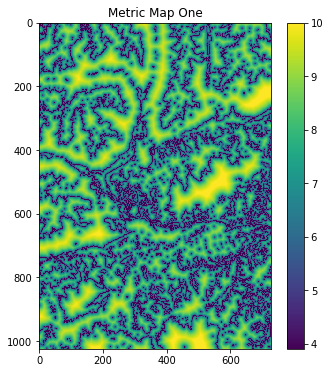

In [14]:
plt.figure(figsize=(6, 6))
plt.imshow(metric1)
plt.title('Metric Map One')
cbar = plt.colorbar()
plt.show()

We want to **mask** innaccessible areas of the metric, so we apply the invalid areas mask we loaded earlier

In [15]:
metric1_mask = np.ma.masked_array(metric1, mask=1-mask)

Now **plot** the masked metric. If you chose not to enter the mask there should be no change...

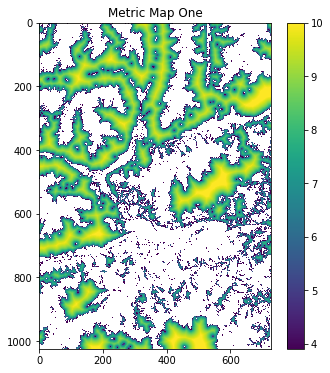

In [16]:
plt.figure(figsize=(6, 6))
plt.imshow(metric1_mask)
plt.title('Metric Map One')
cbar = plt.colorbar()
plt.show()

This map represents the distance to nearest edge value for all pixels within the unmasked landscape. We want to assess the distribution of these metric values. 

### Number of bins
First we **set the number of bins**. This should be **an integer value**, and specifies how many equal intervals the range of the metric should be broken into. E.g:

In [17]:
##########
bins1 = 10
##########

Now plot a histogram showing the distribution of pixel values in each bin.

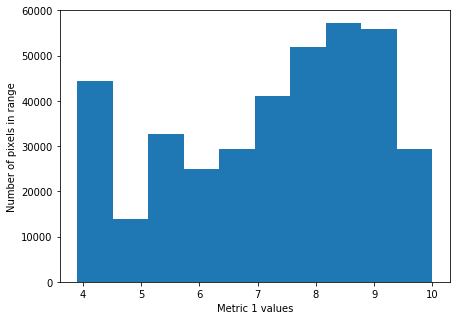

In [18]:
plt.figure(figsize=(7, 5))
plt.hist(metric1_mask.compressed(), bins=bins1)
plt.xlabel('Metric 1 values')
plt.ylabel('Number of pixels in range')
plt.show()

As we can see from the histogram, some metric values are represented by larger areas of the landscape. However if we wish to study response to distance to edge, we should place our sample sites uniformly within the range of the histogram. Try altering the number of bins and see how the distribution changes. 

### Discretize the metric
We now convert the contiuous metric to a categorical metric, where each pixel is labelled according to the bin it falls in in our histogram

In [19]:
def discretize_metric(metric, mask, n_bins):
    """
    Convert continuous metrics to discrete, based on the specified number of bins
    INPUTS:
        metric: (np.array) fragmentation metric map
        mask: (np.array) binary mask showing locations which should not be sampled
        n_bins: (int) number of intervals the range of the metric should be divided into
    OUTPUTS:
        metric_bin: (np.array) the binned fragmentation metric
        ids: (list) the unique id values assigned to each bin
        breaks: (list) the intervals where the range of the metric was split
    """
    imheight, imwidth = metric.shape
    # Mask out invalid areas of metric (numpy masked array function reads one as invalid, so invert mask)
    metric_mask = np.ma.masked_array(metric, mask=(1-mask))
    # Break range of masked metric values into 'n_bins' intervals
    hist, breaks = np.histogram(metric_mask.compressed(), bins=n_bins)
    # Each bin a unique integer ID
    ids = np.arange(0, n_bins)
    ones = np.ones((imheight, imwidth))
    metric_bin = np.zeros((imheight, imwidth))
    # Loop through ID's and convert all values in each bin to corresponding id
    for ID in ids:
        # Closed on the lower bound, open on the top
        lower_lim = np.where(ones, metric_mask >= breaks[ID], 0)
        upper_lim = np.where(ones, metric_mask < breaks[ID+1], 0)
        # Make the last interval closed at the upper bound
        if ID == n_bins-1:
            upper_lim = np.where(ones, metric_mask <= breaks[ID+1], 0)
        metric_bin += lower_lim*upper_lim*ID
    return metric_bin, ids, breaks

Create the binned metric map, record the ids and break points...

In [20]:
metric1_binned, metric1_id, metric1_breaks = discretize_metric(metric1, mask, bins1)
metric1_binned_mask = np.ma.masked_array(metric1_binned, mask=1-mask)

**Plot** the discrete version of the metric map...

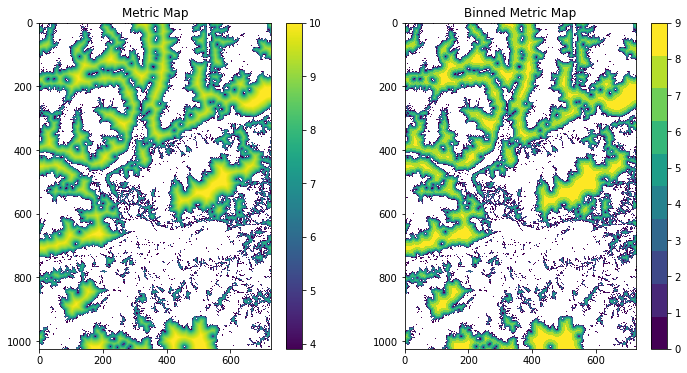

In [21]:
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.imshow(metric1_mask)
plt.title('Metric Map')
plt.colorbar()

plt.subplot(122)
plt.imshow(metric1_binned_mask, cmap=plt.cm.get_cmap('viridis', bins1))
plt.title('Binned Metric Map')
cbar = plt.colorbar()
cbar.set_ticks(metric1_id)
cbar.set_ticklabels(metric1_id)

plt.show()

### Choosing number of sample sites
For this design we want to place an equal number of sites across the range of the metric. We first need to check how many pixels are in each id.

For this one metric case this is simple...

In [22]:
id_counts = []
imheight, imwidth = metric1.shape
all_layers = np.zeros((len(metric1_id), imheight, imwidth))
for idx in metric1_id:
    id_layer = np.where(metric1_binned == idx, 1, 0) * mask
    id_counts.append(np.sum(id_layer))
    all_layers[idx, :, :] = id_layer
    print('There are {} pixels in ID {}'.format(np.sum(id_layer), idx))

There are 44509 pixels in ID 0
There are 13972 pixels in ID 1
There are 32779 pixels in ID 2
There are 25032 pixels in ID 3
There are 29361 pixels in ID 4
There are 40991 pixels in ID 5
There are 51984 pixels in ID 6
There are 57236 pixels in ID 7
There are 55933 pixels in ID 8
There are 29418 pixels in ID 9


We'll save the results in a dataframe...

In [23]:
combo_df = pd.DataFrame()
combo_df['ID'] = metric1_id
combo_df['n_pixels'] = id_counts

In [24]:
combo_df

,ID,n_pixels
0,0,44509
1,1,13972
2,2,32779
3,3,25032
4,4,29361
5,5,40991
6,6,51984
7,7,57236
8,8,55933
9,9,29418


Depending on the number of bins (```bins1```) you chose, some ID's may be empty (i.e n_pixels = 0). If this is the case we remove them from our dataframe.

In [25]:
ID_df = combo_df[combo_df.n_pixels != 0]

In [26]:
def nsp_suggest(ID_df, nsp):
    print('You input {} sample sites, and the number of unique IDs is {}'.format(nsp, len(ID_df)))
    s_opt = nsp/len(ID_df)
    
    if s_opt.is_integer():
        print('There will be exactly {} sample sites in each ID!'.format(int(s_opt)))
        print('There is no need to adjust the number of sample sites')
    else:
        nsp_lower = np.floor(s_opt)*len(ID_df)
        nsp_upper = np.ceil(s_opt)*len(ID_df)
        print('Changing nsp to {} will give {} sites for each ID'.format(int(nsp_lower), int(np.floor(s_opt))))
        print('Changing nsp to {} will give {} sites for each ID'.format(int(nsp_upper), int(np.ceil(s_opt))))
        print('If you choose not to adjust the number of sites, extra points will be placed randomly between the IDs')
        
    return s_opt

In [27]:
s_opt = nsp_suggest(ID_df, nsp)

You input 57 sample sites, and the number of unique IDs is 10
Changing nsp to 50 will give 5 sites for each ID
Changing nsp to 60 will give 6 sites for each ID
If you choose not to adjust the number of sites, extra points will be placed randomly between the IDs


#### Adjust nsp?

In [28]:
#############
nsp = 60
#############

In [29]:
unique_ids = combo_df.loc[combo_df.n_pixels != 0].index.values

In [30]:
def generate_id_list(unique_ids, nsp, id_df):
    """
    Generate a list of ids to sample in the design
    INPUTS:
        unique_ids: (list) list of unique ids contained in id_im
        nsp: (int) integer number of sample sites
        id_df: (data frame) reduced version of combo_df, with all empty ids removed
    OUTPUTS:
        id_mix: (np.array) list of ids to sample, randomly shuffled
        id_df: (data frame) reduced version of combo_df, with all empty ids removed
    """
    s_opt = nsp / len(unique_ids)
    id_rep = np.repeat(unique_ids, np.floor(s_opt))
    diff = nsp - len(id_rep)
    if diff > 0:
        print('difference of {}'.format(diff))
        extra_ids = np.random.choice(unique_ids, diff, replace=False)
        id_rep = np.hstack([id_rep, extra_ids])
    elif diff < 0:
        print('error')
    else:
        print('{} sample sites requested, {} sampled'.format(nsp, len(id_rep)))
    # If nsp is less than the number of IDs (i.e one or less sample per ID),
    # then create a reduced data frame
    if len(id_rep) < len(unique_ids):
        print('creating reduced data frame')
        df_ids = [i - 1 for i in id_rep]
        id_df = id_df.iloc[df_ids, :].copy(deep=True)
    id_df = id_df.assign(freq=np.unique(id_rep, return_counts=True)[1])
    id_mix = np.random.permutation(id_rep)
    return id_mix, id_df

In [31]:
id_mix, ID_df = generate_id_list(unique_ids, nsp, ID_df)

60 sample sites requested, 60 sampled


In [32]:
ID_df

,ID,n_pixels,freq
0,0,44509,6
1,1,13972,6
2,2,32779,6
3,3,25032,6
4,4,29361,6
5,5,40991,6
6,6,51984,6
7,7,57236,6
8,8,55933,6
9,9,29418,6


## Generate uniform design
We are now ready to place sites in our ids. We iterate through the random list of ids, and assign sites based on the distance transform...

In [33]:
def generate_uniform_design(id_mix, id_im):
    """
    Main function for generating a uniform design.
    Places site evenly within the range of the input metrics, while also spacing them as evenly as possible spatially.
    INPUTS:
        id_mix: (list) list of metric id values to be sampled
        id_im: (np.array) distribution of all metric id values in the study landscape
    OUTPUTS:
        x_vals: (list) x coordinates of sample sites
        y_vals: (list) y coordinates of sample sites
    """

    # Initialise empty arrays and lists to save design
    imheight, imwidth = id_im.shape
    dist_im = np.ones((imheight, imwidth))
    sites = np.ones((imheight, imwidth))
    x_vals = []
    y_vals = []
    loop_count = 1

    for i in id_mix:
        print('Plotting site {}, id number {}'.format(loop_count, i))

        # Select binary map relating to selected ID
        mask_id = np.where(id_im == i, 1, 0)

        # Mask out any regions of EDT not in ID
        layer = mask_id * dist_im

        # Extract coordinates of pixels with maximum distance value
        dist_mx = list(zip(*np.where(layer == layer.max())))

        # Choose one max coord pair at random
        idx = randint(0, len(dist_mx) - 1)
        x, y = dist_mx[idx]

        # Save x and y coordinates
        x_vals = np.append(x_vals, x)
        y_vals = np.append(y_vals, y)

        # Code chosen site to be zero in site array
        sites[x, y] = 0

        # Update the euclidean distance transform
        dist_im = ndimage.distance_transform_edt(sites)

        loop_count += 1

    print('Uniform sample design complete!')
    return x_vals, y_vals


In [34]:
x_unif, y_unif = generate_uniform_design(id_mix, metric1_binned)

Plotting site 1, id number 3
Plotting site 2, id number 5
Plotting site 3, id number 5
Plotting site 4, id number 3
Plotting site 5, id number 4
Plotting site 6, id number 4
Plotting site 7, id number 1
Plotting site 8, id number 8
Plotting site 9, id number 6
Plotting site 10, id number 5
Plotting site 11, id number 9
Plotting site 12, id number 4
Plotting site 13, id number 6
Plotting site 14, id number 0
Plotting site 15, id number 1
Plotting site 16, id number 3
Plotting site 17, id number 7
Plotting site 18, id number 9
Plotting site 19, id number 0
Plotting site 20, id number 5
Plotting site 21, id number 7
Plotting site 22, id number 8
Plotting site 23, id number 1
Plotting site 24, id number 7
Plotting site 25, id number 7
Plotting site 26, id number 9
Plotting site 27, id number 6
Plotting site 28, id number 8
Plotting site 29, id number 2
Plotting site 30, id number 5
Plotting site 31, id number 8
Plotting site 32, id number 9
Plotting site 33, id number 3
Plotting site 34, i

# Results

### Plot Design

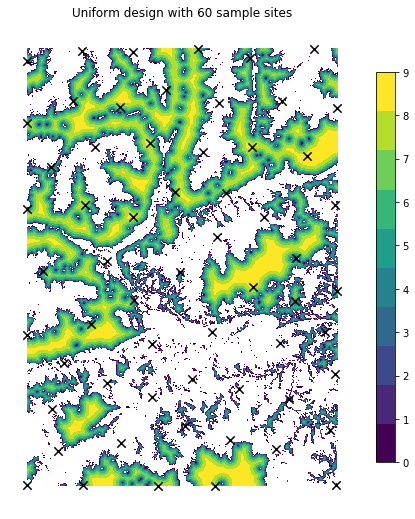

In [35]:
plt.figure(figsize=(7, 9))
plt.imshow(metric1_binned_mask, cmap=plt.cm.get_cmap('viridis', bins1))
plt.title('{} design with {} sample sites'.format('Uniform', len(x_unif)))
plt.axis('off')
cbar = plt.colorbar(fraction=0.05)
cbar.set_ticks(unique_ids)
cbar.set_ticklabels(unique_ids)
plt.scatter(y_unif, x_unif, c='black', marker='x', linewidth=1.5, s=70)
plt.show()

### Save the design

The below function converts the (x, y) coordinates specifying pixels in the image to longitude and latitude coordinates. Geo-information extracted from the input habitat map is used to transform the points to long-lat. 

In [36]:
def lat_long_convert(x, y, prj_info, geo_t):
    """
    Convert x, y coordinates to longitude and latitude, using projection info contained in the geo-tiff
    INPUTS:
        x: (list) x coordinates of sample sites
        y: (list) y coordinates of sample sites
        prj_info: (string) projection information extracted from geo-tiff
        geo_t: (list) geographic transformation values extracted from geo-tiff
    OUTPUTS:
        long: (list) longitude values of sample sites
        lat: (list) latitude values of sample sites
    """
    # Project row and column (will be for bottom left corner)
    x_proj = x * geo_t[1] + geo_t[0]
    y_proj = y * geo_t[5] + geo_t[3]

    # Shift from bottom left to centre of the pixel
    x_proj += geo_t[1] / 2.0
    y_proj += geo_t[5] / 2.0

    xy_proj = np.stack((x_proj, y_proj), axis=-1)

    # Make spatial coordinate system
    srs = osr.SpatialReference()
    if srs.ImportFromWkt(prj_info) != 0:
        print("Error: cannot import projection '%s'" % prj_info)
        sys.exit(1)

    srs_lat_long = srs.CloneGeogCS()
    ct = osr.CoordinateTransformation(srs, srs_lat_long)
    long, lat, height = list(zip(*ct.TransformPoints(xy_proj)))
    return long, lat

def save_uniform(x, y, id_mix, id_df, id_im, prj_info, geo_t, save_path, sampled_csv=None):
    """
    Function to output final sample design to .csv and ESRI .shp file
    INPUTS:
        x: (list) x coordinates of sample sites
        y: (list) y coordinates of sample sites
        prj_info: (string) projection information extracted from geo-tiff
        geo_t: (list) geographic transformation values extracted from geo-tiff
        save_path: (str) path specifying where to save the .csv and .shp files
        sampled_csv: (data frame) only entered if updating a design, else None
    OUTPUTS:
        Saves .csv in the directory specified by save_path
    """
    # Generate unique time stamp to avoid overwriting results
    ts = time.gmtime()
    ts = time.strftime("%y_%m_%d_%H%M%S", ts)
    
    if not os.path.exists('{}/{}'.format(save_path, ts)):
        os.makedirs('{}/{}'.format(save_path, ts))

    # Convert from row/col to projected
    long, lat = lat_long_convert(x, y, prj_info, geo_t)

    # Make data frame using pandas
    result = pd.DataFrame()
    result['longitude'] = long
    result['latitude'] = lat
    result['row'] = x
    result['col'] = y
    result['sampled'] = 0
    result['ID'] = id_mix
    csv_filename = '{}site_unif'.format(len(x))

    # For adapted designs add info to the sampled column
    if sampled_csv is not None:
        num_sampled = sum(sampled_csv.sampled)
        result['sampled'] = [1] * num_sampled + [0] * (len(x) - num_sampled)
        csv_filename = '{}site_unif_adapted'.format(len(x))

    # Merge with id_df to store individual metric id values
    result = pd.merge(result, id_df)
    
    # Write to csv and shape files
    result.index += 1
    result.to_csv('{}/{}/{}.csv'.format(save_path, ts, csv_filename), index_label='site')
    save_as_shp(x, y, geo_t, '{}/{}/{}.shp'.format(save_path, ts, csv_filename))
    np.savez('{}/{}/{}.npz'.format(save_path, ts, csv_filename))
    print('Design saved as .csv and .shp in {}/{} directory \nFile name: {}'.format(save_path, ts, csv_filename))
    print('Also saving id_im as {}.npz, which is used to adapt the uniform design'.format(csv_filename))
    return '{}/{}/{}'.format(directory, ts, csv_filename)

In [37]:
csv_filename = save_uniform(x_unif, y_unif, id_mix, ID_df, metric1_binned, prj_info, geo_t, directory)

Design saved as .csv and .shp in results/Uniform_Design_Demo/20_10_11_175448 directory 
File name: 60site_unif
Also saving id_im as 60site_unif.npz, which is used to adapt the uniform design


### Example output:

You should now be able to navigate to your results folder and open the csv file using your preferred software. We can load and print the first few lines of the output here as a quick check...

In [38]:
view_csv = pd.read_csv('{}.csv'.format(csv_filename))

In [39]:
view_csv[:10]

,site,longitude,latitude,row,col,sampled,ID,n_pixels,freq
0,1,172.279723,-42.560935,23.0,523.0,0,3,25032,6
1,2,172.405165,-42.418166,375.0,0.0,0,3,25032,6
2,3,172.450802,-42.468120,497.0,187.0,0,3,25032,6
3,4,172.523513,-42.577134,689.0,594.0,0,3,25032,6
4,5,172.313916,-42.448698,123.0,109.0,0,3,25032,6
5,6,172.394836,-42.544192,339.0,466.0,0,3,25032,6
6,7,172.640633,-42.415038,1021.0,0.0,0,5,40991,6
7,8,172.551406,-42.611071,763.0,721.0,0,5,40991,6
8,9,172.512698,-42.416798,670.0,0.0,0,5,40991,6
9,10,172.479773,-42.613369,567.0,726.0,0,5,40991,6


Columns consist of:
* A **site** ID
* The coordinates in **longitude** and **latitude**
* The coordinates in **row** and **column** (corresponding to pixels in image)
* A **sampled** column: This is used when generating an *adapted design*. When conducting the survey sites which have been sampled can be tagged with a 1 in this column. Unsampled sites remain tagged with a 0. **For example see demo_adapted_uniform notebook**. 
* An **ID** referring to the metric space ID the site is placed in
* The number of pixels (**n_pixels**) in each metric space ID
* The **freq** each metric space ID is sampled 